### In this notebook we will be implementing custom image augmentation. For machine learning computer vision task, image augmentation have huge impact on the performance of the model.

As shown in this paper, ResNet strikes back: An improved training
procedure in timm (https://arxiv.org/pdf/2110.00476.pdf). Using modern image augmentation to induce regularization effect can greatly improve the model's performance

### In this notebook, we will be focus on implementing cutmix and mixout augmentation
1. In tensorflow
2. In pytorch


## References
1. cutmix https://arxiv.org/abs/1905.04899
2. mixup https://arxiv.org/abs/1710.09412
3. https://www.kaggle.com/cdeotte/cutmix-and-mixup-on-gpu-tpu/notebook

## Importing the data

In [1]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1qxQnSwa70PtN_cVSylXYmhDvYUUfmBtQ' -O flower.zip
!unzip /content/flower.zip -d flowers

--2021-12-01 03:14:33--  https://docs.google.com/uc?export=download&id=1qxQnSwa70PtN_cVSylXYmhDvYUUfmBtQ
Resolving docs.google.com (docs.google.com)... 173.194.212.101, 173.194.212.139, 173.194.212.113, ...
Connecting to docs.google.com (docs.google.com)|173.194.212.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-cc-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/uau9j3fvu5dpc2d6v7kn8t8ftlu58pcc/1638328425000/13410031516798976466/*/1qxQnSwa70PtN_cVSylXYmhDvYUUfmBtQ?e=download [following]
--2021-12-01 03:14:36--  https://doc-00-cc-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/uau9j3fvu5dpc2d6v7kn8t8ftlu58pcc/1638328425000/13410031516798976466/*/1qxQnSwa70PtN_cVSylXYmhDvYUUfmBtQ?e=download
Resolving doc-00-cc-docs.googleusercontent.com (doc-00-cc-docs.googleusercontent.com)... 173.194.218.132, 2607:f8b0:400c:c14::84
Connecting to doc-00-cc-docs.googleusercontent.com (doc-00

## Import libraries

In [2]:
#tensorflow library
import tensorflow as tf

#pytorch library
import torch

#plotting library
import matplotlib.pyplot as plt

#python library
import glob
import os

#numpy
import numpy as np

## Config file

In [3]:
class Config:
    batchsize=8
    image_size = 256

### Getting image filepaths

In [4]:
image_fps = glob.glob("flowers/*.jpg")
image_labels = [os.path.basename(image_fp).split("_")[0] for image_fp in image_fps]
unique_labels = list(set(image_labels))
image_label_mapping = {name:i for i, name in enumerate(unique_labels)}
image_labels = [image_label_mapping[label] for label in image_labels]
n_classes = len(unique_labels)

# Tensorflow

## Dataset functions

In [31]:
def tf_load_image(fp, label):
    bin_image = tf.io.read_file(fp) #binary string
    image_tensor = tf.io.decode_jpeg(bin_image) # tf.tensor() 0-255
    image_tensor = tf.image.resize(image_tensor, (Config.image_size, Config.image_size))
    image_tensor = tf.image.convert_image_dtype(image_tensor,dtype=tf.float32)/255.0 # tf.tensor() 0-1
    return image_tensor, label

def cutmix(image, label, prob=1.0):
    # function will receive a batch of images
    new_imgs = []
    new_labels = []

    # repeat for each image
    for j in range(Config.batchsize):
        P = tf.cast(tf.random.uniform([],0,1)<=prob, tf.int32) # 0 or 1
        K = tf.random.uniform([], 0, Config.batchsize, dtype=tf.int32) #which image to mix in 0 - batchsize-1
        
        #position of the center of the cutout
        x_center = tf.random.uniform([],0,Config.image_size, dtype=tf.int32)
        y_center = tf.random.uniform([],0,Config.image_size, dtype=tf.int32)
        b = tf.random.uniform([],0,1)
        width = tf.cast(Config.image_size * tf.sqrt(1-b), tf.int32) * P
        x1 = tf.math.maximum(0, x_center-width//2)
        y1 = tf.math.maximum(0, y_center-width//2)
        x2 = tf.math.minimum(Config.image_size, x_center+width//2)
        y2 = tf.math.minimum(Config.image_size, y_center+width//2)

        #tensorflow constant does not allow assignment so we need to reconstruct the new image
        image_left = image[j,y1:y2,:x1,:] 
        image_cutout = image[K,y1:y2,x1:x2,:]
        image_right = image[j,y1:y2,x2:,:]

        central_image = tf.concat([image_left, image_cutout,image_right], axis=1)
        new_image = tf.concat([image[j,:y1,:,:],central_image,image[j,y2:,:,:]], axis=0)
        new_imgs.append(new_image)
    
        percentage_replaced = tf.cast(width*width/Config.image_size/Config.image_size, tf.float32)

        label_1 = tf.one_hot(label[j],n_classes)
        label_2 = tf.one_hot(label[K],n_classes)

        new_labels.append(label_1*(1-percentage_replaced)+label_2*percentage_replaced)


    new_image_batch = tf.reshape(tf.stack(new_imgs), (Config.batchsize,Config.image_size,Config.image_size,3))
    new_label_batch = tf.reshape(tf.stack(new_labels), (Config.batchsize,n_classes))

    return new_image_batch, new_label_batch

def mixup(image, label, prob=1.0):
    """mixup will receive a batch of images"""

    new_imgs = []
    new_labs = []

    for i in range(Config.batchsize):
        P =tf.cast(tf.random.uniform([],0,1) <=prob, dtype=tf.float32) #P is 0 or 1
        k =tf.random.uniform([],0, Config.batchsize, dtype=tf.int32) #which image to mix with
        a =tf.random.uniform([],0,1) * P

        img1 = image[i]
        img2 = image[k]
        new_imgs.append((1-a)*img1+a*img2)

        lab1 = tf.one_hot(label[i], n_classes)
        lab2 = tf.one_hot(label[k], n_classes)

        new_labs.append((1-a)*lab1 + a *lab2)

    new_image_batch = tf.reshape(tf.stack(new_imgs), (Config.batchsize,Config.image_size, Config.image_size, 3))
    new_label_batch = tf.reshape(tf.stack(new_labs), (Config.batchsize, n_classes))

    return new_image_batch, new_label_batch

def cutmix_and_mixup(image,label):
    # Taken from https://www.kaggle.com/cdeotte/cutmix-and-mixup-on-gpu-tpu
    SWITCH = 0.5
    CUTMIX_PROB = 0.666
    MIXUP_PROB = 0.666

    image3, label3 = mixup(image, label, MIXUP_PROB)
    image2, label2 = cutmix(image, label, CUTMIX_PROB)
    

    new_images =[]
    new_labels =[]
    for i in range(Config.batchsize):
        P = tf.cast(tf.random.uniform([], 0,1) <=SWITCH, dtype=tf.float32)
        new_images.append((1-P)*image2[i,] + P*image3[i,])
        new_labels.append((1-P)*label2[i,] + P*label3[i,])

    new_image_batch = tf.reshape(tf.stack(new_images),(Config.batchsize,Config.image_size,Config.image_size,3))
    new_label_batch = tf.reshape(tf.stack(new_labels),(Config.batchsize,n_classes))

    return new_image_batch, new_label_batch
    


## Cutmix

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
tf_dataset = tf.data.Dataset.from_tensor_slices((image_fps,image_labels))
tf_dataset = tf_dataset.map(tf_load_image, num_parallel_calls=AUTOTUNE)
tf_dataset = tf_dataset.repeat() # the dataset must repeat for several epochs
tf_dataset = tf_dataset.batch(Config.batchsize)
tf_dataset = tf_dataset.map(cutmix, num_parallel_calls=AUTOTUNE)
tf_dataset = tf_dataset.unbatch()
tf_dataset = tf_dataset.shuffle(2048)
tf_dataset = tf_dataset.batch(Config.batchsize).prefetch(AUTOTUNE)

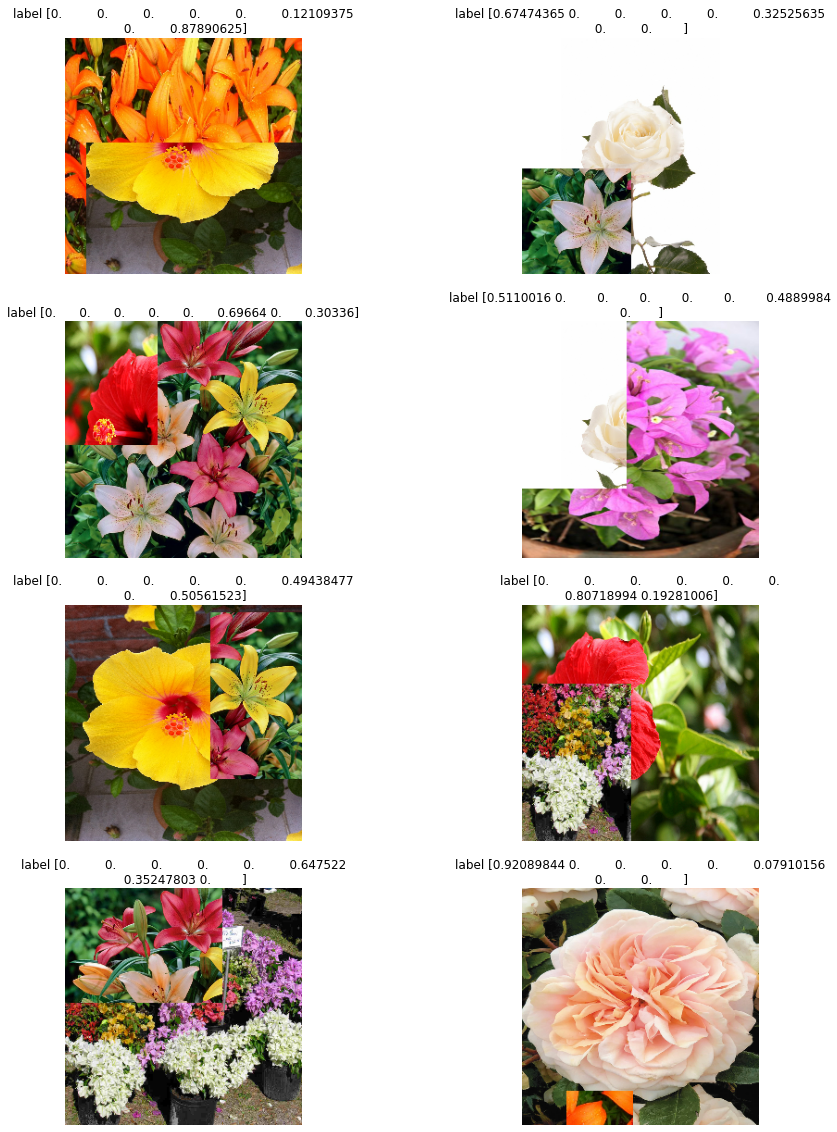

In [ ]:
fig = plt.figure(figsize=(15,20))
for images, labels in tf_dataset.take(1):
    for i, (image, label) in enumerate(zip(images.numpy(),labels.numpy())):
        ax = fig.add_subplot(4,2,i+1)
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f"label {label}")

plt.show()

## Mixup

In [15]:
AUTOTUNE = tf.data.AUTOTUNE
tf_dataset = tf.data.Dataset.from_tensor_slices((image_fps,image_labels))
tf_dataset = tf_dataset.map(tf_load_image, num_parallel_calls=AUTOTUNE)
tf_dataset = tf_dataset.repeat() # the dataset must repeat for several epochs
tf_dataset = tf_dataset.batch(Config.batchsize)
tf_dataset = tf_dataset.map(mixup, num_parallel_calls=AUTOTUNE)
tf_dataset = tf_dataset.unbatch()
tf_dataset = tf_dataset.shuffle(2048)
tf_dataset = tf_dataset.batch(Config.batchsize).prefetch(AUTOTUNE)

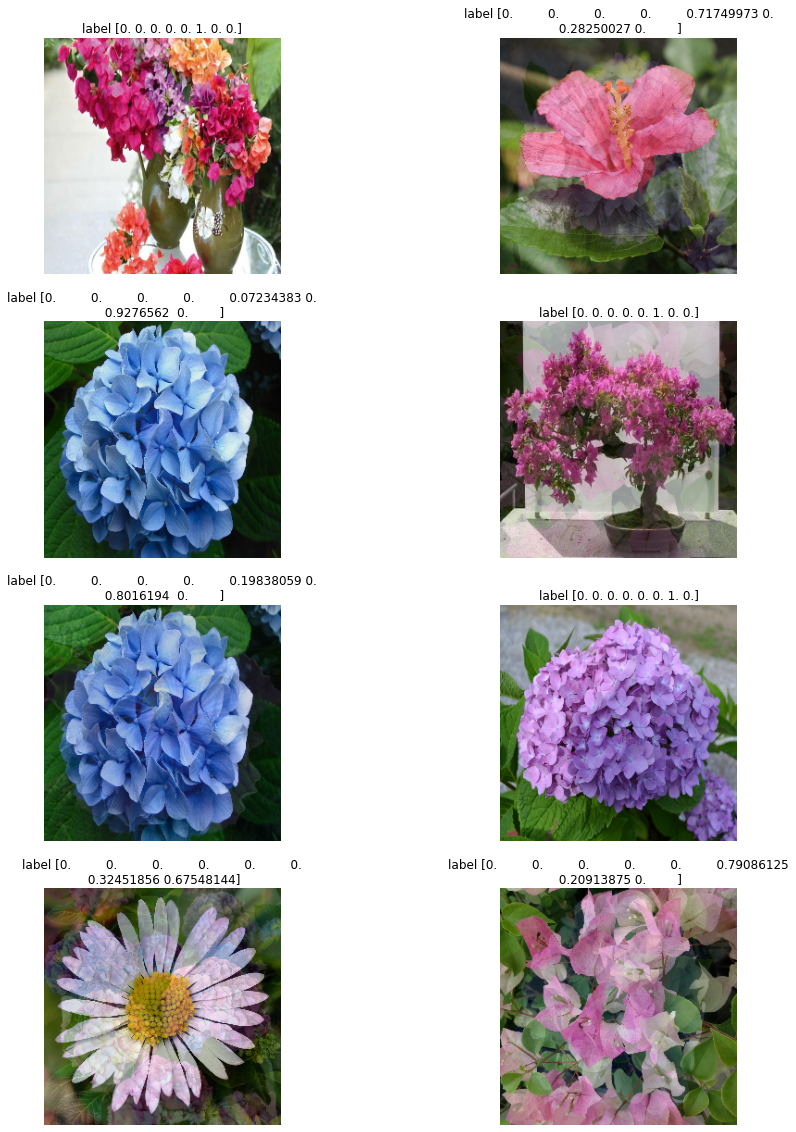

In [17]:
fig = plt.figure(figsize=(15,20))
for images, labels in tf_dataset.take(1):
    for i, (image, label) in enumerate(zip(images.numpy(),labels.numpy())):
        ax = fig.add_subplot(4,2,i+1)
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f"label {label}")

plt.show()

## Combining mixup and cutmix

In [34]:
AUTOTUNE = tf.data.AUTOTUNE
tf_dataset = tf.data.Dataset.from_tensor_slices((image_fps,image_labels))
tf_dataset = tf_dataset.shuffle(2048)
tf_dataset = tf_dataset.map(tf_load_image, num_parallel_calls=AUTOTUNE)
tf_dataset = tf_dataset.repeat() # the dataset must repeat for several epochs
tf_dataset = tf_dataset.batch(Config.batchsize)
tf_dataset = tf_dataset.map(cutmix_and_mixup, num_parallel_calls=AUTOTUNE)
tf_dataset = tf_dataset.unbatch()
tf_dataset = tf_dataset.shuffle(2048)
tf_dataset = tf_dataset.batch(Config.batchsize).prefetch(AUTOTUNE)

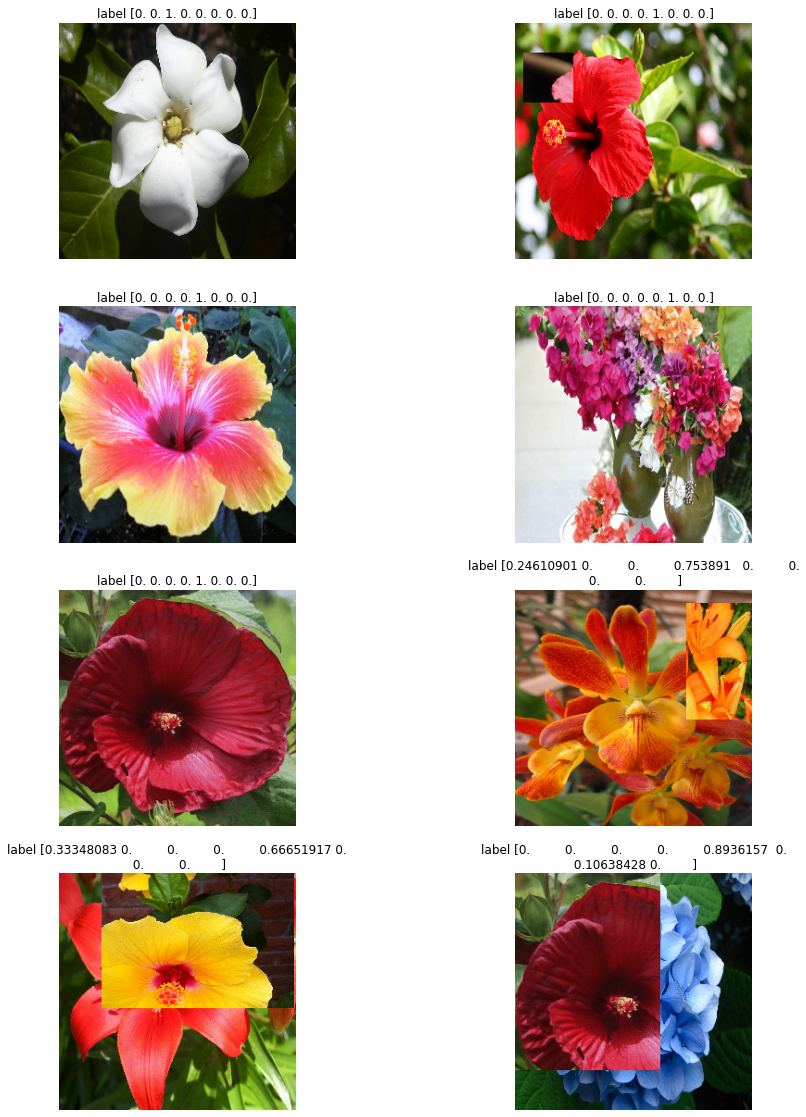

In [35]:
fig = plt.figure(figsize=(15,20))
for images, labels in tf_dataset.take(1):
    for i, (image, label) in enumerate(zip(images.numpy(),labels.numpy())):
        ax = fig.add_subplot(4,2,i+1)
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f"label {label}")

plt.show()

# Pytorch